# import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from sklearn.model_selection import KFold
import tensorflow as tf
from tqdm import tqdm
from transformers import BertTokenizer,TFBertModel,RobertaTokenizer,TFRobertaModel,XLNetTokenizer,TFXLNetModel
from tensorflow.keras.layers import Dense,Dropout,Input,Conv1D,BatchNormalization
%matplotlib inline

In [2]:
print(tf.__version__)

2.6.0


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2021-12-02 13:43:24.513555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 13:43:24.625845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 13:43:24.626599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
import os
import random as rn
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [5]:
df=pd.read_csv('../input/google-quest-challenge/train.csv')

In [6]:
pd.options.display.max_columns=None

In [7]:
df.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [8]:
df.isna().sum()

qa_id                                    0
question_title                           0
question_body                            0
question_user_name                       0
question_user_page                       0
answer                                   0
answer_user_name                         0
answer_user_page                         0
url                                      0
category                                 0
host                                     0
question_asker_intent_understanding      0
question_body_critical                   0
question_conversational                  0
question_expect_short_answer             0
question_fact_seeking                    0
question_has_commonly_accepted_answer    0
question_interestingness_others          0
question_interestingness_self            0
question_multi_intent                    0
question_not_really_a_question           0
question_opinion_seeking                 0
question_type_choice                     0
question_ty

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6079 entries, 0 to 6078
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   qa_id                                  6079 non-null   int64  
 1   question_title                         6079 non-null   object 
 2   question_body                          6079 non-null   object 
 3   question_user_name                     6079 non-null   object 
 4   question_user_page                     6079 non-null   object 
 5   answer                                 6079 non-null   object 
 6   answer_user_name                       6079 non-null   object 
 7   answer_user_page                       6079 non-null   object 
 8   url                                    6079 non-null   object 
 9   category                               6079 non-null   object 
 10  host                                   6079 non-null   object 
 11  ques

In [10]:
df.shape

(6079, 41)

In [11]:
df.columns

Index(['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host', 'question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfa

In [12]:
PRE_NAME='bert-base-uncased'
#PRE_NAME='bert-large-uncased'
#PRE_NAME='roberta-base'
#PRE_NAME='roberta-large'
#PRE_NAME='xlnet-base-cased'
#PRE_NAME='xlnet-large-cased'
HEADS=1

In [13]:
if PRE_NAME.startswith('bert'):
    tokenizer=BertTokenizer.from_pretrained(PRE_NAME)
    print(f"the input format is \n")
    print(tokenizer('Example where we will have first sentence here','Example where we will have second sentence here',
                   max_length=40,padding='max_length',truncation='longest_first'))
    print("\n the tokens are\n")
    print(tokenizer.convert_ids_to_tokens(tokenizer('Example where we will have first sentence here','Example where we will have second sentence here',
                   max_length=40,padding='max_length',truncation='longest_first')['input_ids']))
elif PRE_NAME.startswith('roberta'):
    tokenizer=RobertaTokenizer.from_pretrained(PRE_NAME)
    print(tokenizer(' Example where we will have first sentence here',' Example where we will have second sentence here',
                   max_length=40,padding='max_length',truncation='longest_first'))
    print("\n the tokens are\n")
    print(tokenizer.convert_ids_to_tokens(tokenizer(' Example where we will have first sentence here',' Example where we will have second sentence here',
                   max_length=40,padding='max_length',truncation='longest_first')['input_ids']))
else:
    tokenizer=XLNetTokenizer.from_pretrained(PRE_NAME)
    print(tokenizer('Example where we will have first sentence here','Example where we will have second sentence here',
                   max_length=40,padding='max_length',truncation='longest_first'))
    print("\n the tokens are\n")
    print(tokenizer.convert_ids_to_tokens(tokenizer('Example where we will have first sentence here','Example where we will have second sentence here',
                   max_length=40,padding='max_length',truncation='longest_first')['input_ids']))

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

the input format is 

{'input_ids': [101, 2742, 2073, 2057, 2097, 2031, 2034, 6251, 2182, 102, 2742, 2073, 2057, 2097, 2031, 2117, 6251, 2182, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

 the tokens are

['[CLS]', 'example', 'where', 'we', 'will', 'have', 'first', 'sentence', 'here', '[SEP]', 'example', 'where', 'we', 'will', 'have', 'second', 'sentence', 'here', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [14]:
cols=['question_title', 'question_body','answer']
for col in cols:
    lens=[]
    for i in tqdm(range(df.shape[0])):
        lens.append(len(tokenizer.tokenize(df.loc[i,col])))
    print(f"{col} has len distribution\n")
    print(pd.Series(lens).describe())
    print('\n##############\n')

100%|██████████| 6079/6079 [00:02<00:00, 2759.19it/s]


question_title has len distribution

count    6079.000000
mean       12.259089
std         5.486514
min         2.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        63.000000
dtype: float64

##############



100%|██████████| 6079/6079 [00:27<00:00, 222.83it/s]


question_body has len distribution

count    6079.000000
mean      227.475736
std       336.998146
min         0.000000
25%        77.000000
50%       134.000000
75%       251.000000
max      6849.000000
dtype: float64

##############



100%|██████████| 6079/6079 [00:27<00:00, 223.80it/s]

answer has len distribution

count    6079.000000
mean      216.351703
std       287.876347
min         4.000000
25%        75.000000
50%       137.000000
75%       257.000000
max      9319.000000
dtype: float64

##############



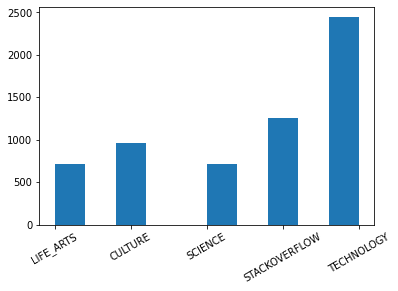

In [15]:
plt.hist(df['category'])
plt.xticks(rotation=30)
plt.show()

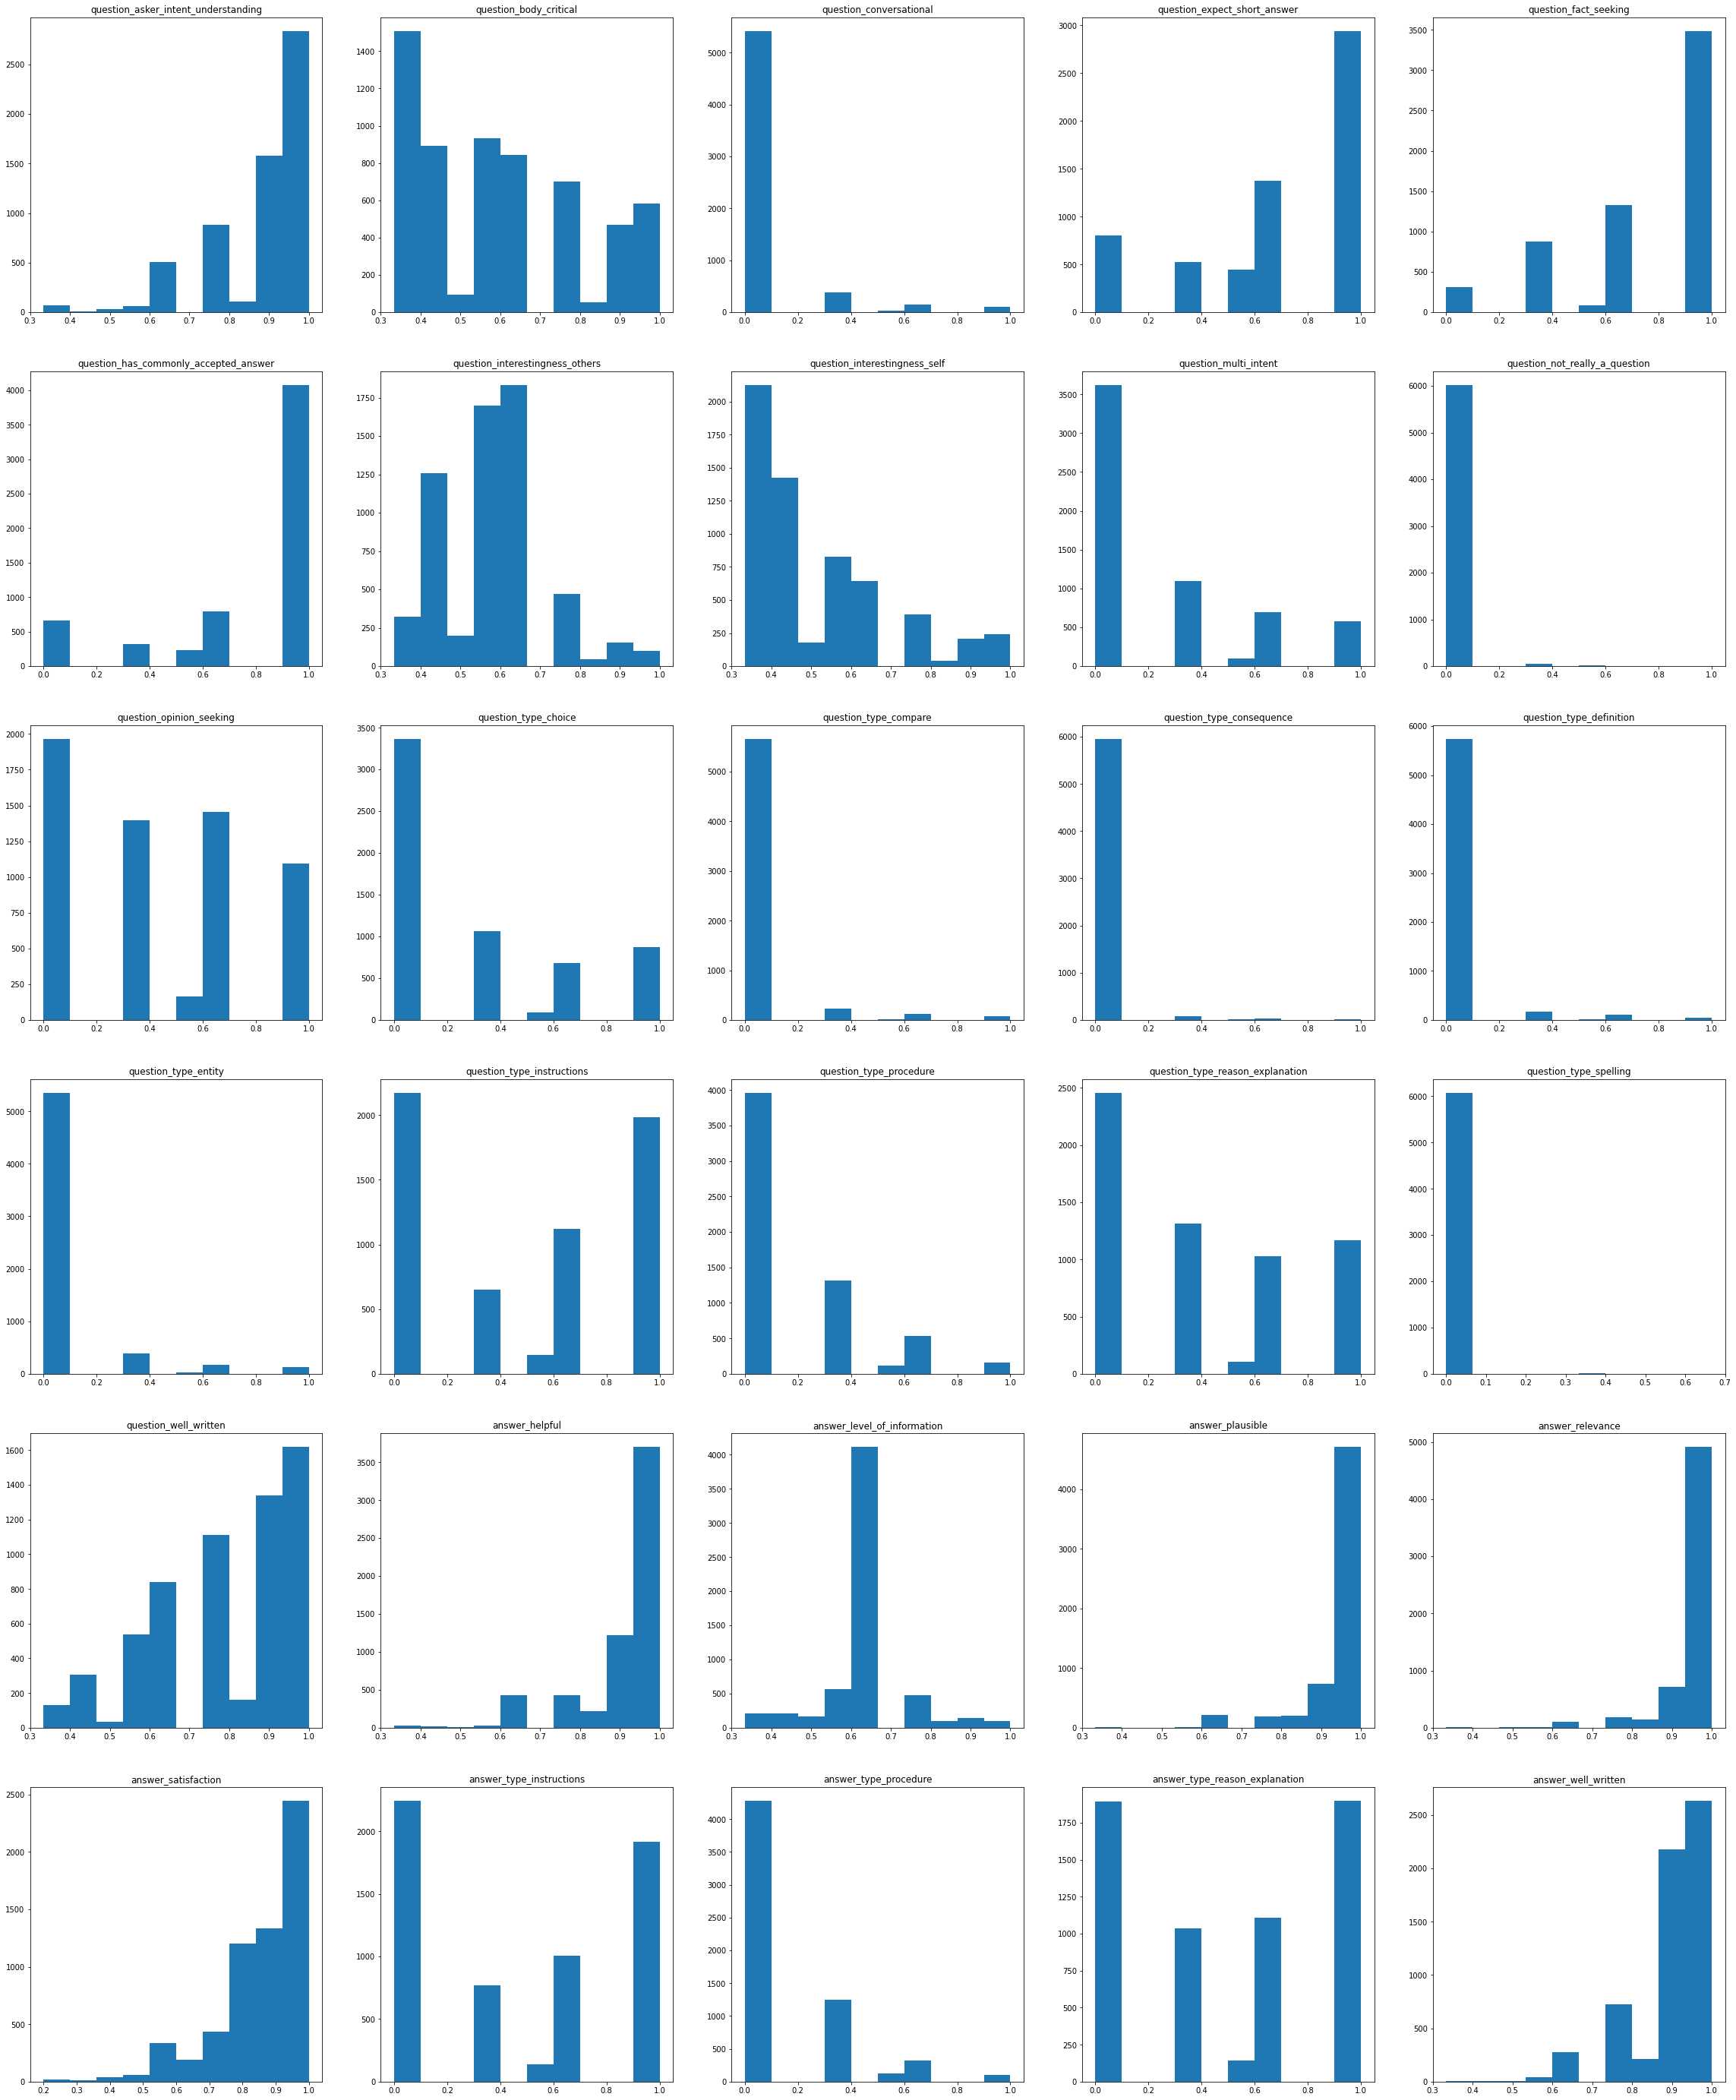

In [16]:
cols=['question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written']
plt.subplots(6,5,figsize=(40,50))
for i,col in enumerate(cols):
    plt.subplot(6,5,i+1)
    plt.hist(df[col])
    plt.title(col)
plt.show()

In [17]:
kfold=KFold(n_splits=5)
df['kfold']=-1
for i,(train,test) in enumerate(kfold.split(df[['question_title', 'question_body','answer']],df[cols])):
    df.loc[test,'kfold']=i

In [18]:
df['kfold'].value_counts()

0    1216
1    1216
2    1216
3    1216
4    1215
Name: kfold, dtype: int64

# input types for models
 
 title&q,title&a
 
 title&q,a
 
 title,q&  title,a
 
 title,q&  q,a 

# models
bert,roberta,xlnet

In [19]:
MAX_LENGTH=512
#h1=[['question_title', 'question_body'],['question_title','answer']]
#h2=[]
####################
h1=[['question_title', 'question_body'],['answer']]
h2=[]
####################
#h1=[['question_title', 'question_body'],['question_body','answer']]
#h2=[]
#####################
#h1=[['question_body'],['question_title','answer']]
#h2=[]
#######################
#h1=[['question_title'],['question_body','answer']]
#h2=[]
#####################
#h1=[['question_title'],[ 'question_body']]
#h2=[['question_title'],['answer']]
#######################
#h1=[['question_title'],[ 'question_body']]
#h2=[['question_body'],['answer']]

# bert related input

In [20]:
def get_bert_single_head_inputs(tokenizer,s1,s2,max_length):
    s1=tokenizer.tokenize(s1)
    s2=tokenizer.tokenize(s2)
    s_len=max_length-3
    s1_len=len(s1)
    s2_len=len(s2)
    if s1_len+s2_len==s_len:
        total_tokens=['[CLS]']+s1+['[SEP]']+s2+['[SEP]']
    elif s1_len+s2_len<s_len:
        total_tokens=['[CLS]']+s1+['[SEP]']+s2+['[SEP]']
    else:
        if s_len%2==0: #even length so, lets divide equally
            req_s1_len=s_len//2
            req_s2_len=s_len//2
        else:
            req_s1_len=s_len//2
            req_s2_len=(s_len//2)+1
        if s1_len<=req_s1_len and s2_len>req_s2_len:
            # s1 is shorter but s2 is longer
            s2=s2[:s_len-s1_len]
            total_tokens=['[CLS]']+s1+['[SEP]']+s2+['[SEP]']
        elif s1_len>req_s1_len and s2_len<=req_s2_len:
            # s1 is longer but s2 is shorter
            s1=s1[:s_len-s2_len]
            total_tokens=['[CLS]']+s1+['[SEP]']+s2+['[SEP]']
        elif s1_len>req_s1_len and s2_len>req_s2_len:
            # both are longer
            s1=s1[:req_s1_len]
            s2=s2[:req_s2_len]
            total_tokens=['[CLS]']+s1+['[SEP]']+s2+['[SEP]']
    total_tokens=total_tokens+['[PAD]']*(max_length-len(total_tokens))
    input_ids=tokenizer.convert_tokens_to_ids(total_tokens)
    attention_mask=np.char.not_equal(total_tokens,'[PAD]').astype('int32')
    token_type_ids=[]
    seq_num=0
    for tok in total_tokens:
        if tok=='[SEP]':
            token_type_ids.append(seq_num)
            seq_num=1-seq_num
        else:
            token_type_ids.append(seq_num)
    return input_ids,attention_mask,token_type_ids

# roberta related input

In [21]:
def get_roberta_single_head_inputs(tokenizer,s1,s2,max_length):
    s1=tokenizer.tokenize(s1)
    s2=tokenizer.tokenize(s2)
    s_len=max_length-4
    s1_len=len(s1)
    s2_len=len(s2)
    if s1_len+s2_len==s_len:
        total_tokens=['<s>']+s1+['</s>']+['</s>']+s2+['</s>']
    elif s1_len+s2_len<s_len:
        total_tokens=['<s>']+s1+['</s>']+['</s>']+s2+['</s>']
    else:
        if s_len%2==0: #even length so, lets divide equally
            req_s1_len=s_len//2
            req_s2_len=s_len//2
        else:
            req_s1_len=s_len//2
            req_s2_len=(s_len//2)+1
        if s1_len<=req_s1_len and s2_len>req_s2_len:
            # s1 is shorter but s2 is longer
            s2=s2[:s_len-s1_len]
            total_tokens=['<s>']+s1+['</s>']+['</s>']+s2+['</s>']
        elif s1_len>req_s1_len and s2_len<=req_s2_len:
            # s1 is longer but s2 is shorter
            s1=s1[:s_len-s2_len]
            total_tokens=['<s>']+s1+['</s>']+['</s>']+s2+['</s>']
        elif s1_len>req_s1_len and s2_len>req_s2_len:
            # both are longer
            s1=s1[:req_s1_len]
            s2=s2[:req_s2_len]
            total_tokens=['<s>']+s1+['</s>']+['</s>']+s2+['</s>']
    total_tokens=total_tokens+['<pad>']*(max_length-len(total_tokens))
    input_ids=tokenizer.convert_tokens_to_ids(total_tokens)
    attention_mask=np.char.not_equal(total_tokens,'<pad>').astype('int32')
    return input_ids,attention_mask

# xlnet related input

In [22]:
def get_xlnet_single_head_inputs(tokenizer,s1,s2,max_length):
    s1=tokenizer.tokenize(s1)
    s2=tokenizer.tokenize(s2)
    s_len=max_length-3
    s1_len=len(s1)
    s2_len=len(s2)
    if s1_len+s2_len==s_len:
        total_tokens=s1+['<sep>']+s2+['<sep>']+['<cls>']
    elif s1_len+s2_len<s_len:
        total_tokens=s1+['<sep>']+s2+['<sep>']+['<cls>']
    else:
        if s_len%2==0: #even length so, lets divide equally
            req_s1_len=s_len//2
            req_s2_len=s_len//2
        else:
            req_s1_len=s_len//2
            req_s2_len=(s_len//2)+1
        if s1_len<=req_s1_len and s2_len>req_s2_len:
            # s1 is shorter but s2 is longer
            s2=s2[:s_len-s1_len]
            total_tokens=s1+['<sep>']+s2+['<sep>']+['<cls>']
        elif s1_len>req_s1_len and s2_len<=req_s2_len:
            # s1 is longer but s2 is shorter
            s1=s1[:s_len-s2_len]
            total_tokens=s1+['<sep>']+s2+['<sep>']+['<cls>']
        elif s1_len>req_s1_len and s2_len>req_s2_len:
            # both are longer
            s1=s1[:req_s1_len]
            s2=s2[:req_s2_len]
            total_tokens=s1+['<sep>']+s2+['<sep>']+['<cls>']
    token_type_ids=[]
    seq_num=0
    for tok in total_tokens:
        if tok=='<sep>':
            token_type_ids.append(seq_num)
            seq_num=1-seq_num
        elif tok=='<cls>':
            token_type_ids.append(2)
        else:
            token_type_ids.append(seq_num)
    token_type_ids=[3]*(max_length-len(total_tokens))+token_type_ids
    total_tokens=['<pad>']*(max_length-len(total_tokens))+total_tokens
    input_ids=tokenizer.convert_tokens_to_ids(total_tokens)
    attention_mask=np.char.not_equal(total_tokens,'<pad>').astype('int32')
    return input_ids,attention_mask,token_type_ids

In [23]:
def get_inputs(data,h1,h2,inference=False):
    columns=data.columns.tolist()
    y_columns=['question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written']
    if len(h2)==0:# single head model
        INPUT_IDS=np.empty((data.shape[0],MAX_LENGTH),dtype=np.int32)
        ATTENTION_MASK=np.empty((data.shape[0],MAX_LENGTH),dtype=np.int32)
        if not inference:
            Y=np.empty((data.shape[0],30))
        if not PRE_NAME.startswith('roberta'):
            TOKEN_TYPE_IDS=np.empty((data.shape[0],MAX_LENGTH),dtype=np.int32)
        for i in range(data.shape[0]):
            t1,t2=h1
            s1=' '.join(data.loc[i,t1].values)
            s2=' '.join(data.loc[i,t2].values)
            if PRE_NAME.startswith('bert'):
                INPUT_IDS[i,],ATTENTION_MASK[i,],TOKEN_TYPE_IDS[i,]=get_bert_single_head_inputs(tokenizer,s1,s2,MAX_LENGTH)
            elif PRE_NAME.startswith('xlnet'):
                INPUT_IDS[i,],ATTENTION_MASK[i,],TOKEN_TYPE_IDS[i,]=get_xlnet_single_head_inputs(tokenizer,s1,s2,MAX_LENGTH)
            else:
                INPUT_IDS[i,],ATTENTION_MASK[i,]=get_roberta_single_head_inputs(tokenizer,' '+s1,' '+s2,MAX_LENGTH)
            if not inference:
                Y[i,]=data.loc[i,y_columns]
        if not PRE_NAME.startswith('roberta') and not inference:
            return INPUT_IDS,ATTENTION_MASK,TOKEN_TYPE_IDS,Y
        if not PRE_NAME.startswith('roberta') and inference:
            return INPUT_IDS,ATTENTION_MASK,TOKEN_TYPE_IDS
        else:
            if not inference:
                return INPUT_IDS,ATTENTION_MASK,Y
            else:
                return INPUT_IDS,ATTENTION_MASK
    else:
        INPUT_IDS1=np.empty((data.shape[0],MAX_LENGTH),dtype=np.int32)
        ATTENTION_MASK1=np.empty((data.shape[0],MAX_LENGTH),dtype=np.int32)
        INPUT_IDS2=np.empty((data.shape[0],MAX_LENGTH),dtype=np.int32)
        ATTENTION_MASK2=np.empty((data.shape[0],MAX_LENGTH),dtype=np.int32)
        if not inference:
            Y=np.empty((data.shape[0],30))
        if not PRE_NAME.startswith('roberta'):
            TOKEN_TYPE_IDS1=np.empty((data.shape[0],MAX_LENGTH),dtype=np.int32)
            TOKEN_TYPE_IDS2=np.empty((data.shape[0],MAX_LENGTH),dtype=np.int32)
        for i in range(data.shape[0]):
            t1,t2=h1
            s1=' '.join(data.loc[i,t1].values)
            s2=' '.join(data.loc[i,t2].values)
            if PRE_NAME.startswith('bert'):
                INPUT_IDS1[i,],ATTENTION_MASK1[i,],TOKEN_TYPE_IDS1[i,]=get_bert_single_head_inputs(tokenizer,s1,s2,MAX_LENGTH)
            elif PRE_NAME.startswith('xlnet'):
                INPUT_IDS1[i,],ATTENTION_MASK1[i,],TOKEN_TYPE_IDS1[i,]=get_xlnet_single_head_inputs(tokenizer,s1,s2,MAX_LENGTH)
            else:
                INPUT_IDS1[i,],ATTENTION_MASK1[i,]=get_roberta_single_head_inputs(tokenizer,' '+s1,' '+s2,MAX_LENGTH)
            t1,t2=h2
            s1=' '.join(data.loc[i,t1].values)
            s2=' '.join(data.loc[i,t2].values)
            if PRE_NAME.startswith('bert'):
                INPUT_IDS2[i,],ATTENTION_MASK2[i,],TOKEN_TYPE_IDS2[i,]=get_bert_single_head_inputs(tokenizer,s1,s2,MAX_LENGTH)
            elif PRE_NAME.startswith('xlnet'):
                INPUT_IDS2[i,],ATTENTION_MASK2[i,],TOKEN_TYPE_IDS2[i,]=get_xlnet_single_head_inputs(tokenizer,s1,s2,MAX_LENGTH)
            else:
                INPUT_IDS2[i,],ATTENTION_MASK2[i,]=get_roberta_single_head_inputs(tokenizer,' '+s1,' '+s2,MAX_LENGTH)
            if not inference:
                Y[i,]=data.loc[i,y_columns]
        if not PRE_NAME.startswith('roberta') and not inference:
            return INPUT_IDS1,ATTENTION_MASK1,TOKEN_TYPE_IDS1,INPUT_IDS2,ATTENTION_MASK2,TOKEN_TYPE_IDS2,Y
        if not PRE_NAME.startswith('roberta') and inference:
            return INPUT_IDS1,ATTENTION_MASK1,TOKEN_TYPE_IDS1,INPUT_IDS2,ATTENTION_MASK2,TOKEN_TYPE_IDS2
        else:
            if not inference:
                return INPUT_IDS1,ATTENTION_MASK1,INPUT_IDS2,ATTENTION_MASK2,Y
            else:
                return INPUT_IDS1,ATTENTION_MASK1,INPUT_IDS2,ATTENTION_MASK2

In [24]:
def get_final_model_inputs(data,h1,h2,inference=False):
    if HEADS==1:
        if not PRE_NAME.startswith('roberta'):
            if not inference:
                INPUT_IDS,ATTENTION_MASK,TOKEN_TYPE_IDS,Y=get_inputs(data,h1,h2,inference)
            else:
                INPUT_IDS,ATTENTION_MASK,TOKEN_TYPE_IDS=get_inputs(data,h1,h2,inference)
            model_inputs={'input_ids':INPUT_IDS,
                         'attention_mask':ATTENTION_MASK,
                         'token_type_ids':TOKEN_TYPE_IDS}
            if not inference:
                model_outputs=Y
        else:
            if not inference:
                INPUT_IDS,ATTENTION_MASK,Y=get_inputs(data,h1,h2,inference)
            else:
                INPUT_IDS,ATTENTION_MASK=get_inputs(data,h1,h2,inference)
            model_inputs={'input_ids':INPUT_IDS,
                         'attention_mask':ATTENTION_MASK
                         }
            if not inference:
                model_outputs=Y
    else:
        if not PRE_NAME.startswith('roberta'):
            if not inference:
                INPUT_IDS1,ATTENTION_MASK1,TOKEN_TYPE_IDS1,INPUT_IDS2,ATTENTION_MASK2,TOKEN_TYPE_IDS2,Y=get_inputs(data,h1,h2,inference)
            else:
                INPUT_IDS1,ATTENTION_MASK1,TOKEN_TYPE_IDS1,INPUT_IDS2,ATTENTION_MASK2,TOKEN_TYPE_IDS2=get_inputs(data,h1,h2,inference)
            model_inputs=[{'input_ids1':INPUT_IDS1,
                         'attention_mask1':ATTENTION_MASK1,
                         'token_type_ids1':TOKEN_TYPE_IDS1},
                          {'input_ids2':INPUT_IDS2,
                         'attention_mask2':ATTENTION_MASK2,
                         'token_type_ids2':TOKEN_TYPE_IDS2}]
            if not inference:
                model_outputs=Y
        else:
            if not inference:
                INPUT_IDS1,ATTENTION_MASK1,INPUT_IDS2,ATTENTION_MASK2,Y=get_inputs(data,h1,h2,inference)
            else:
                INPUT_IDS1,ATTENTION_MASK1,INPUT_IDS2,ATTENTION_MASK2=get_inputs(data,h1,h2,inference)
            model_inputs=[{'input_ids1':INPUT_IDS1,
                         'attention_mask1':ATTENTION_MASK1},
                          {'input_ids2':INPUT_IDS2,
                         'attention_mask2':ATTENTION_MASK2}]
            if not inference:
                model_outputs=Y
    if not inference:
        return model_inputs,model_outputs
    else:
        return model_inputs

# models

In [25]:
PRE_NAME='bert-base-uncased'
#PRE_NAME='bert-large-uncased'
#PRE_NAME='roberta-base'
#PRE_NAME='roberta-large'
#PRE_NAME='xlnet-base-cased'
#PRE_NAME='xlnet-large-cased'
HEADS=1
MAX_LENGTH=512

# single head model

In [26]:
def SINGLE_MODEL(sequence=False,final_activation=True,hidden_states=True,hidden_number=4):
    tf.keras.backend.clear_session()
    if PRE_NAME.startswith('bert'):
        ins1=Input((MAX_LENGTH,),dtype=tf.int32)
        ins2=Input((MAX_LENGTH,),dtype=tf.int32)
        ins3=Input((MAX_LENGTH,),dtype=tf.int32)
        pre_model=TFBertModel.from_pretrained(PRE_NAME,output_hidden_states=hidden_states,return_dict=True)
        pre_layers=pre_model({'input_ids':ins1,'attention_mask':ins2,'token_type_ids':ins3})
    elif PRE_NAME.startswith('xlnet'):
        ins1=Input((MAX_LENGTH,),dtype=tf.int32)
        ins2=Input((MAX_LENGTH,),dtype=tf.int32)
        ins3=Input((MAX_LENGTH,),dtype=tf.int32)
        pre_model=TFXLNetModel.from_pretrained(PRE_NAME,output_hidden_states=hidden_states,return_dict=True)
        pre_layers=pre_model({'input_ids':ins1,'attention_mask':ins2,'token_type_ids':ins3})
    else:
        ins1=Input((MAX_LENGTH,),dtype=tf.int32)
        ins2=Input((MAX_LENGTH,),dtype=tf.int32)
        pre_model=TFRobertaModel.from_pretrained(PRE_NAME,output_hidden_states=hidden_states,return_dict=True)
        pre_layers=pre_model({'input_ids':ins1,'attention_mask':ins2})
    if sequence:
        x=Conv1D(1,1)(pre_layers[0])
        x=tf.squeeze(x,axis=-1)
        x=BatchNormalization()(x)
        x=Dropout(0.1)(x)
        x=tf.keras.layers.ReLU()(x)
    elif hidden_states:
        if not PRE_NAME.startswith('xlnet'):
            x=tf.stack([layer[:,0,:] for layer in pre_layers[2][-hidden_number:]],axis=-1)
            x=tf.keras.layers.Flatten()(x)
            x=Dense(768*hidden_number,activation='tanh')(x)
        else:
            x=tf.stack([layer[:,-1,:] for layer in pre_layers[2][-hidden_number:]],axis=-1)
            x=tf.keras.layers.Flatten()(x)
            x=Dense(768*hidden_number,activation='tanh')(x)
    else:
        if not PRE_NAME.startswith('xlnet'):
            x=pre_layers[1]
        else:
            x=pre_layers[0][:,-1,:]
        x=BatchNormalization()(x)
        x=Dropout(0.1)(x)
    if final_activation:
        outs=Dense(30,activation='sigmoid')(x)
    else:
        outs=Dense(30)(x)
    if not PRE_NAME.startswith('roberta'):
        model=tf.keras.models.Model(inputs={'input_ids':ins1,'attention_mask':ins2,'token_type_ids':ins3},outputs=outs)
    else:
        model=tf.keras.models.Model(inputs={'input_ids':ins1,'attention_mask':ins2},outputs=outs)
    return model

# double head model

In [27]:
def DOUBLE_MODEL(sequence=False,final_activation=True,hidden_states=True):
    tf.keras.backend.clear_session()
    if PRE_NAME.startswith('bert'):
        ins1=Input((MAX_LENGTH,),dtype=tf.int32)
        ins2=Input((MAX_LENGTH,),dtype=tf.int32)
        ins3=Input((MAX_LENGTH,),dtype=tf.int32)
        ins4=Input((MAX_LENGTH,),dtype=tf.int32)
        ins5=Input((MAX_LENGTH,),dtype=tf.int32)
        ins6=Input((MAX_LENGTH,),dtype=tf.int32)
        pre_model=TFBertModel.from_pretrained(PRE_NAME,output_hidden_states=hidden_states,return_dict=True)
        pre_layers1=pre_model({'input_ids':ins1,'attention_mask':ins2,'token_type_ids':ins3})
        pre_layers2=pre_model({'input_ids':ins4,'attention_mask':ins5,'token_type_ids':ins6})
    elif PRE_NAME.startswith('xlnet'):
        ins1=Input((MAX_LENGTH,),dtype=tf.int32)
        ins2=Input((MAX_LENGTH,),dtype=tf.int32)
        ins3=Input((MAX_LENGTH,),dtype=tf.int32)
        ins4=Input((MAX_LENGTH,),dtype=tf.int32)
        ins5=Input((MAX_LENGTH,),dtype=tf.int32)
        ins6=Input((MAX_LENGTH,),dtype=tf.int32)
        pre_model=TFXLNetModel.from_pretrained(PRE_NAME,output_hidden_states=hidden_states,return_dict=True)
        pre_layers1=pre_model({'input_ids':ins1,'attention_mask':ins2,'token_type_ids':ins3})
        pre_layers2=pre_model({'input_ids':ins4,'attention_mask':ins5,'token_type_ids':ins6})
    else:
        ins1=Input((MAX_LENGTH,),dtype=tf.int32)
        ins2=Input((MAX_LENGTH,),dtype=tf.int32)
        ins3=Input((MAX_LENGTH,),dtype=tf.int32)
        ins4=Input((MAX_LENGTH,),dtype=tf.int32)
        pre_model=TFRobertaModel.from_pretrained(PRE_NAME,output_hidden_states=hidden_states,return_dict=True)
        pre_layers1=pre_model({'input_ids':ins1,'attention_mask':ins2})
        pre_layers2=pre_model({'input_ids':ins3,'attention_mask':ins4})
    if sequence:
        x1=Conv1D(1,1)(pre_layers1[0])
        x1=tf.squeeze(x1,axis=-1)
        x1=BatchNormalization()(x1)
        x1=Dropout(0.1)(x1)
        x1=tf.keras.layers.ReLU()(x1)
        x2=Conv1D(1,1)(pre_layers2[0])
        x2=tf.squeeze(x2,axis=-1)
        x2=BatchNormalization()(x2)
        x2=Dropout(0.1)(x2)
        x2=tf.keras.layers.ReLU()(x2)
        x=tf.keras.layers.Concatenate()([x1,x2])
    elif hidden_states:
        if not PRE_NAME.startswith('xlnet'):
            x1=tf.stack([layer[:,0,:] for layer in pre_layers1[2]],axis=-1)
            x1=tf.squeeze(Conv1D(1,1)(x1),axis=-1)
            x1=BatchNormalization()(x1)
            x1=Dropout(0.1)(x1)
            x1=tf.keras.layers.ReLU()(x1)
            x2=tf.stack([layer[:,0,:] for layer in pre_layers2[2]],axis=-1)
            x2=tf.squeeze(Conv1D(1,1)(x2),axis=-1)
            x2=BatchNormalization()(x2)
            x2=Dropout(0.1)(x2)
            x2=tf.keras.layers.ReLU()(x2)
        else:
            x1=tf.stack([layer[:,-1,:] for layer in pre_layers1[2]],axis=-1)
            x1=tf.squeeze(Conv1D(1,1)(x1),axis=-1)
            x1=BatchNormalization()(x1)
            x1=Dropout(0.1)(x1)
            x1=tf.keras.layers.ReLU()(x1)
            x2=tf.stack([layer[:,-1,:] for layer in pre_layers2[2]],axis=-1)
            x2=tf.squeeze(Conv1D(1,1)(x2),axis=-1)
            x2=BatchNormalization()(x2)
            x2=Dropout(0.1)(x2)
            x2=tf.keras.layers.ReLU()(x2)
        x=tf.keras.layers.Concatenate()([x1,x2])
    else:
        if not PRE_NAME.startswith('xlnet'):
            x1=pre_layers1[1]
            x1=BatchNormalization()(x1)
            x1=Dropout(0.1)(x1)
            x2=pre_layers2[1]
            x2=BatchNormalization()(x2)
            x2=Dropout(0.1)(x2)
        else:
            x1=pre_layers1[0][:,-1,:]
            x1=BatchNormalization()(x1)
            x1=Dropout(0.1)(x1)
            x2=pre_layers2[0][:,-1,:]
            x2=BatchNormalization()(x2)
            x2=Dropout(0.1)(x2)
        x=tf.keras.layers.Concatenate()([x1,x2])
    if final_activation:
        outs=Dense(30,activation='sigmoid')(x)
    else:
        outs=Dense(30)(x)
    if not PRE_NAME.startswith('roberta'):
        model=tf.keras.models.Model(inputs=[{'input_ids1':ins1,'attention_mask1':ins2,'token_type_ids1':ins3},
                                            {'input_ids2':ins4,'attention_mask2':ins5,'token_type_ids2':ins6}]
                                    ,outputs=outs)
    else:
        model=tf.keras.models.Model(inputs=[{'input_ids1':ins1,'attention_mask1':ins2},
                                            {'input_ids2':ins3,'attention_mask2':ins4}]
                                    ,outputs=outs)
    
    return model

In [28]:
import tensorflow.keras.backend as K

In [29]:
def custom_loss(y_true,y_pred):
    y_true=tf.cast(y_true,dtype=y_pred.dtype)
    bce=K.mean(-1*((y_true*K.log(y_pred+1e-5))+((1-y_true)*K.log(1-y_pred+1e-5))),axis=-1)
    rmsle=K.sqrt(K.mean(K.square(K.log(y_true+1)-K.log(y_pred+1))))
    total_loss=bce+rmsle
    return K.mean(total_loss)

In [30]:
lr=3e-5
loss='binary_crossentropy'
name='bert_4_hiddens_type2_bce'
batch_size=8

In [31]:
batch_size

8

In [32]:
for i in range(5):
    train=df[df['kfold']!=i].drop('kfold',axis=1).reset_index(drop=True)
    test=df[df['kfold']==i].drop('kfold',axis=1).reset_index(drop=True)
    model_inputs,model_outputs=get_final_model_inputs(train,h1,h2,inference=False)
    print("\nsome samples of training data\n")
    print(model_inputs,model_outputs)
    valid_inputs,valid_outputs=get_final_model_inputs(test,h1,h2,inference=False)
    print("\nsome samples of testing data\n")
    print(valid_inputs,valid_outputs)
    print('\nsummary of the model\n')
    model=SINGLE_MODEL(sequence=False,final_activation=True,hidden_states=True,hidden_number=4)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                 loss=loss)
    early=tf.keras.callbacks.EarlyStopping(patience=3,monitor='val_loss',mode='min',verbose=1,restore_best_weights=True)
    saver=tf.keras.callbacks.ModelCheckpoint(monitor='val_loss',mode='min',save_best_only=True,
                                            save_weights_only=True,save_freq='epoch',filepath=f"{name}_fold_{i}.h5",verbose=1)
    model.fit(model_inputs,model_outputs,epochs=20,batch_size=batch_size,
              validation_data=(valid_inputs,valid_outputs),
             callbacks=[early,saver])
    print(f"\nloss for fold {i} we got {model.evaluate(valid_inputs,valid_outputs)}\n")
    del model
    import gc
    gc.collect()


some samples of training data

{'input_ids': array([[  101,  2064,  1045, ...,     0,     0,     0],
       [  101,  2590,  2512, ...,     0,     0,     0],
       [  101,  2695, 17603, ...,     0,     0,     0],
       ...,
       [  101, 16081,  1005, ...,     0,     0,     0],
       [  101,  2043,  2323, ...,     0,     0,     0],
       [  101,  2339,  2024, ...,     0,     0,     0]], dtype=int32), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)} [[0.88888889 1.         0.         ... 0.         0.66666667 1.        ]
 [1.         0.88888889 0.66666667 ... 0.   

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

2021-12-02 13:46:05.167041: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-02 13:46:05.168803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 13:46:05.169611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 13:46:05.170286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_2[0][0]                    
                                                                 input_1[0][0]                

2021-12-02 13:46:19.153430: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-02 13:46:33.925281: I tensorflow/stream_executor/cuda/cuda_driver.cc:732] failed to allocate 7.04G (7559970816 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


608/608 [==============================] - 390s 617ms/step - loss: 0.3865 - val_loss: 0.3744

Epoch 00001: val_loss improved from inf to 0.37443, saving model to bert_4_hiddens_type2_bce_fold_0.h5
Epoch 2/20
608/608 [==============================] - 373s 614ms/step - loss: 0.3596 - val_loss: 0.3712

Epoch 00002: val_loss improved from 0.37443 to 0.37123, saving model to bert_4_hiddens_type2_bce_fold_0.h5
Epoch 3/20
608/608 [==============================] - 388s 638ms/step - loss: 0.3441 - val_loss: 0.3774

Epoch 00003: val_loss did not improve from 0.37123
Epoch 4/20
608/608 [==============================] - 388s 639ms/step - loss: 0.3271 - val_loss: 0.3870

Epoch 00004: val_loss did not improve from 0.37123
Epoch 5/20
608/608 [==============================] - 388s 639ms/step - loss: 0.3094 - val_loss: 0.3985
Restoring model weights from the end of the best epoch.

Epoch 00005: val_loss did not improve from 0.37123
Epoch 00005: early stopping
38/38 [==============================] 

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_2[0][0]                    
                                                                 input_1[0][0]                

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_2[0][0]                    
                                                                 input_1[0][0]                

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_2[0][0]                    
                                                                 input_1[0][0]                

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_2[0][0]                    
                                                                 input_1[0][0]                

In [33]:
#when using single cls token as output
# for 1st H1,H2 bert gave 0.35417 for bce loss and 0.1 dropout
# roberta,xlnet gave around 0.35 only
#for remaining H1,H2 score is aroung 0.34...  and less than bert score in 1st H1,H2only
##################################################################

In [34]:
# after running bert base. the bench mark decided is 0.36262

In [35]:
#for h1=[['question_title', 'question_body'],['question_title','answer']]
#h2=[]
#using 4 hidden states
# bert,0.1,3e-5->0.35909
# roberta,0.1,3e-5-> 0.35331
# roberta,0.1,1e-5-> 0.35096
# sequence
# bert,0.1,3e-5->0.28393

In [36]:
#for h1=[['question_title', 'question_body'],['answer']]
#h2=[]
# using 4 hidden states
#bert,3e-5,0.1->0.36262
#roberta,3e-5,0.1->0.35200
#xlnet,3e-5,0.1->0.35375

In [37]:
#h1=[['question_title', 'question_body'],['question_body','answer']]
#h2=[]
#bert with 4 hidden states-> 0.33143

In [38]:
#h1=[['question_body'],['question_title','answer']]
#h2=[]
#using 4 hidden states
#bert,3e-5,0.1->0.35709

In [39]:
#h1=[['question_title'],['question_body','answer']]
#h2=[]
#using 4 hidden states
#bert,3e-5,0.1->0.33911